In [1]:
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer

import ipytest
ipytest.autoconfig()

In [3]:
df = pd.read_csv(Path("in/VideoCommentsThreatCorpus.csv"))
df.head()

,label,text
0,0,It's because Europeans do not want to change t...
1,0,The Muslims there do not want to assimilate pr...
2,1,But it's ok....because Europe will soon rebel ...
3,0,I forsee a big civil war in Europe in the futu...
4,0,"ISLAM – A Simple, Humanitarian and Attractive ..."


## Cleaning data
- remove non-word stuff (short)
- remove newline (if problem)

In [72]:
def clean_text(text: pd.Series) -> pd.Series:
    """ Remove whitespace and punctuation """
    return text.str.replace(r'\s+', ' ', regex=True).str.replace(r'[^\w\s]', '', regex=True).str.rstrip()

df["clean_text"] = clean_text(df["text"])
text_filter = df["clean_text"].str.len() > 10
clean_df = df[text_filter]

## Exploring the distribution of labels

<AxesSubplot:>

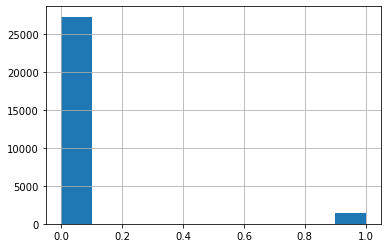

In [9]:
df["label"].hist()

We have an extremely skewed distribution going on here, which we need to be quite aware of when building the pipeline

### MVP Pipeline

In [89]:
%%ipytest

from typing import Tuple
def resample(X: pd.Series, y: pd.Series, sampler: RandomUnderSampler) -> Tuple[pd.Series, pd.Series]:
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled

def test_resample():
    X = pd.Series({"a": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
    y = pd.Series([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])
    sampler = RandomUnderSampler()
    X_resampled, y_resampled = resample(X, y, sampler)
    assert X_resampled.shape == (6, 1)
    assert y_resampled.shape == (6,)

def test_resample_str():
    X = pd.DataFrame({"a": ["1", "2", "3", "4", "5", "6", "hej", "sej", "nej", "jeg er en banan"]})
    y = pd.Series([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])
    sampler = RandomUnderSampler()
    X_resampled, y_resampled = resample(X, y, sampler)
    assert X_resampled.shape == (6, 1)
    assert y_resampled.shape == (6,)

..                                                                                           [100%]
2 passed in 0.03s


In [93]:
from imblearn.pipeline import make_pipeline
# import randomundersampler from imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

sampler = RandomUnderSampler(random_state=1)
#vectorizer = CountVectorizer()
logistic = LogisticRegression()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(clean_df["clean_text"], clean_df["label"], test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = resample(X_train, y_train, sampler)


#pipe = make_pipeline(vectorizer, logistic)
#X_new = pipe.fit_transform(X_train_resampled, y_train_resampled)

ValueError: Found input variables with inconsistent numbers of samples: [1, 2262]

In [102]:
# Create scikit-learn pipeline that first transform the text column to a vector and then does logistic regression
# import column transformer
from sklearn.compose import ColumnTransformer 
# import pipeline from sklearn
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

pipe = Pipeline([
    ("resample", sampler),
    ('column_transformer', ColumnTransformer([
        ('comment_text_vectorizer', vectorizer, 'clean_text')], remainder='drop')),
    ('model', LogisticRegression())])

pipe.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('resample', RandomUnderSampler(random_state=1)),
                ('column_transformer',
                 ColumnTransformer(transformers=[('comment_text_vectorizer',
                                                  TfidfVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'clean_text')])),
                ('model', LogisticRegression())])

<AxesSubplot:>

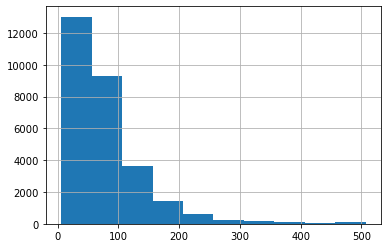

In [56]:
df["text"].str.len().hist()

In [57]:
df["text"].str.len().describe()

count    28643.000000
mean        79.156932
std         63.638563
min          6.000000
25%         37.000000
50%         62.000000
75%         99.000000
max        507.000000
Name: text, dtype: float64

In [61]:
crit = df["text"].str.len() < 15
df[crit]

,label,text
233,0,wake up West!\n
415,0,Is it Sexual?\n
494,1,kill them all\n
534,0,God is great.\n
660,0,Lets move on.\n
...,...,...
28330,0,they will DIE\n
28350,0,peace to all\n
28527,0,we need you\n
28564,0,ha ha ha ha!\n
